## 1.ライブラリのImport

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import japanize_matplotlib
sns.set(font="IPAexGothic")
%matplotlib inline

In [2]:
# 前処理
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# LightGBM
import optuna.integration.lightgbm as lgb

# 評価指標
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


C:\Users\adachike\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2.データの読み込み

In [3]:
base_train = pd.read_csv('.\\train\\base_train.csv')
processing_train = pd.read_csv('.\\train\\processing_train.csv')
actual_train = pd.read_csv('.\\train\\actual_train.csv')
base_test = pd.read_csv('.\\test\\base_test.csv')
processing_test = pd.read_csv('.\\test\\processing_test.csv')
actual_test = pd.read_csv('.\\test\\actual_test.csv')

C:\Users\adachike\AppData\Local\Temp\ipykernel_20556\4254642946.py:1: DtypeWarning: Columns (2,9,15,24,33,34,35,38,39,43,45,46,48,49,50) have mixed types. Specify dtype option on import or set low_memory=False.
  base_train = pd.read_csv('.\\train\\base_train.csv')
C:\Users\adachike\AppData\Local\Temp\ipykernel_20556\4254642946.py:2: DtypeWarning: Columns (12,13,15,16,22,23,30,33,34,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,61,63,65) have mixed types. Specify dtype option on import or set low_memory=False.
  processing_train = pd.read_csv('.\\train\\processing_train.csv')


## 3.データの前処理

・欠損値の削除  
・2020/4/20から付帯時間の定義が変わっているので変更  
・trainとtestで前処理が異なる、同じ関数だとエラーが出力されるため  
※欠損値が多すぎる・・・・  

In [4]:
def preprocessing_train(actual_train,processing_train,base_train):
    train_merged = pd.merge(processing_train,actual_train,on =["受注番号","号機名"])
    train_merged = pd.merge(train_merged,base_train,on =["受注番号"])
    train_merged["作業日"] = pd.to_datetime(train_merged["作業日"])
    train_merged = train_merged[train_merged["号機名"].isin(["グルアー","2号機","4号機","6号機","7号機","8号機"])]
    train_merged["付帯時間"] = train_merged["合計時間"].where(train_merged["作業日"] >= "2020-02-04",train_merged["所要時間"] - (train_merged["作業時間"] + train_merged["残業時間"]))
    train_merged = train_merged[(train_merged['付帯時間']>0)&(train_merged['作業時間']>0)] 
    train_df = train_merged[["受注番号","号機名","数量1","合計数量","予備数量","仕上数量","連量","加工数量","製品仕様コード_x","カテゴリ名1","カテゴリ名2","表色数","裏色数","流用受注番号","展開寸法幅","展開寸法長さ","作業時間","付帯時間"]]
    return train_df

In [5]:
def preprocessing_test(actual_test,processing_test,base_train):
    test_merged = pd.merge(processing_test,actual_test,on =["受注番号","号機名"])
    test_merged = pd.merge(test_merged,base_test,on=["受注番号"])
    test_merged["作業日"] = pd.to_datetime(test_merged["作業日"])
    test_merged = test_merged[test_merged["号機名"].isin(["グルアー","2号機","4号機","6号機","7号機","8号機"])]
    test_df = test_merged[["受注番号","号機名","数量1","合計数量","予備数量","仕上数量","連量","加工数量","製品仕様コード_x","カテゴリ名1","カテゴリ名2","表色数","裏色数","流用受注番号","展開寸法幅","展開寸法長さ"]]
    test_df["予備数量"][test_df["予備数量"].isnull()] = 0
    test_df["加工数量"][test_df["加工数量"].isnull()] = 0
    test_df["合計数量"][test_df["合計数量"].isnull()] = 0
    test_df["仕上数量"][test_df["仕上数量"].isnull()] = 0
    return test_df

In [6]:
df_test = preprocessing_test(actual_test,processing_test,base_test)
df_train = preprocessing_train(actual_train,processing_train,base_train)

C:\Users\adachike\AppData\Local\Temp\ipykernel_20556\575234342.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["予備数量"][test_df["予備数量"].isnull()] = 0
C:\Users\adachike\AppData\Local\Temp\ipykernel_20556\575234342.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["予備数量"][test_df["予備数量"].isnull()] = 0
C:\Users\adachike\AppData\Local\Temp\ipykernel_20556\575234342.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  te

データの確認

C:\Users\adachike\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='付帯時間', ylabel='Density'>

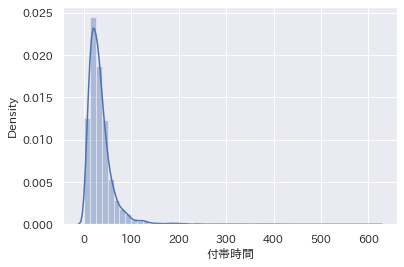

In [7]:
sns.distplot(df_train["付帯時間"])  

<AxesSubplot:xlabel='付帯時間', ylabel='作業時間'>

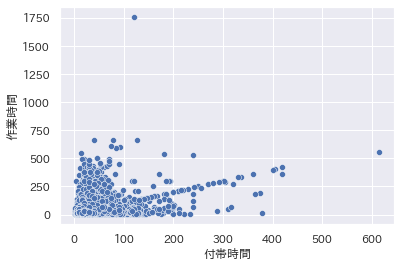

In [8]:
sns.scatterplot(x="付帯時間", y="作業時間", data=df_train)

外れ値の削除

In [9]:
work_time_quantile = df_train["作業時間"].quantile(0.95)
hutai_time_quantile = df_train["付帯時間"].quantile(0.95)
df_train = df_train.query('作業時間 < @work_time_quantile')
df_train = df_train.query("付帯時間 < @hutai_time_quantile")
df_train[["作業時間","付帯時間"]].describe()

,作業時間,付帯時間
count,9532.000000,9532.000000
mean,20.490138,29.219261
std,21.272424,16.717027
min,1.000000,1.000000
25%,7.000000,16.000000
50%,13.000000,26.000000
75%,25.000000,39.000000
max,121.000000,80.000000


C:\Users\adachike\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='作業時間', ylabel='Density'>

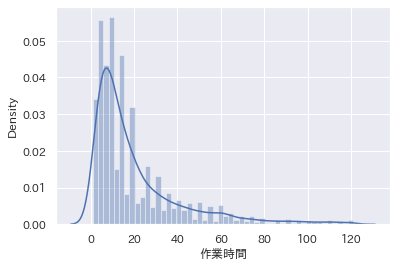

In [10]:
sns.distplot(df_train["作業時間"])

<AxesSubplot:xlabel='付帯時間', ylabel='作業時間'>

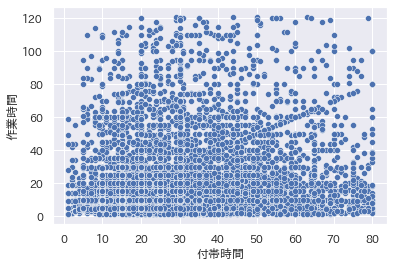

In [11]:
sns.scatterplot(x="付帯時間", y="作業時間", data=df_train)

In [12]:
df_train[["作業時間","付帯時間"]].describe()

,作業時間,付帯時間
count,9532.000000,9532.000000
mean,20.490138,29.219261
std,21.272424,16.717027
min,1.000000,1.000000
25%,7.000000,16.000000
50%,13.000000,26.000000
75%,25.000000,39.000000
max,121.000000,80.000000


In [13]:
#グルアーの前処理
def preprocessing_gruar_train(df):
    gruar = df[df["号機名"] == "グルアー"]
    gruar_ID = gruar[["受注番号","号機名"]]
    gruar_ID.reset_index(inplace=True,drop=True)
    gruar.drop(["表色数","裏色数","カテゴリ名1","受注番号","号機名"],axis=1,inplace=True)
    gruar["合計数量"] = gruar["合計数量"].where(gruar["合計数量"] >0,gruar["数量1"])
    gruar["数量1"][gruar["数量1"] == "« NULL »"] = gruar["合計数量"][gruar["数量1"] == "« NULL »"]
    
    gruar["展開寸法幅"][gruar["展開寸法幅"].isnull()] = 0
    gruar["展開寸法長さ"][gruar["展開寸法長さ"].isnull()] = 0
    gruar["展開寸法幅"][gruar["展開寸法幅"] == "« NULL »"] = 0
    gruar["展開寸法長さ"][gruar["展開寸法長さ"] == "« NULL »"] = 0

    gruar["展開寸法幅"] = gruar["展開寸法幅"].astype(float)
    gruar["展開寸法長さ"] = gruar["展開寸法長さ"].astype(float)

    gruar["流用受注番号"][gruar["流用受注番号"] == "« NULL »"] = 0
    gruar["流用受注番号"][gruar["流用受注番号"].notnull()] = 1
    gruar["流用受注番号"][gruar["流用受注番号"].isnull()] = 0
    gruar["流用受注番号"] = gruar["流用受注番号"].astype(int)

    gruar["数量1"] = gruar["数量1"].astype(float)
    gruar["カテゴリ名2"][gruar["カテゴリ名2"].isnull()] = "コートボール"
    gruar["合計数量"] = gruar["合計数量"].astype(float)
    gruar["予備数量"] = gruar["予備数量"].astype(float)
    gruar["連量"][gruar["連量"].isnull()] = 0
    gruar["仕上数量"] = gruar["仕上数量"].astype(float)
    gruar["加工数量"] = gruar["加工数量"].astype(float)
    gruar.drop(["カテゴリ名2"],axis=1,inplace=True)
    gruar = pd.get_dummies(gruar)
    return gruar,gruar_ID


In [14]:
#印刷の前処理
def preprocessing_print_train(df):
    print = df[df["号機名"] != "グルアー"]
    print_ID = print[["受注番号","号機名"]]
    print_ID.reset_index(inplace=True,drop=True)
    print.drop(["合計数量","予備数量","仕上数量","加工数量","受注番号"],axis=1,inplace=True)

    print["展開寸法幅"][print["展開寸法幅"].isnull()] = 0
    print["展開寸法長さ"][print["展開寸法長さ"].isnull()] = 0
    print["展開寸法幅"][print["展開寸法幅"] == "« NULL »"] = 0
    print["展開寸法長さ"][print["展開寸法長さ"] == "« NULL »"] = 0

    print["展開寸法幅"] = print["展開寸法幅"].astype(float)
    print["展開寸法長さ"] = print["展開寸法長さ"].astype(float)

    print["流用受注番号"][print["流用受注番号"] == "« NULL »"] = 0
    print["流用受注番号"][print["流用受注番号"].notnull()] = 1
    print["流用受注番号"][print["流用受注番号"].isnull()] = 0
    print["流用受注番号"] = print["流用受注番号"].astype(int)

    print["表色数"][print["表色数"].isnull()]  = 0
    print["裏色数"][print["裏色数"].isnull()] = 0
    print["カテゴリ名1"][print["カテゴリ名1"].isnull()] = "平判"
    print["カテゴリ名2"][print["カテゴリ名2"].isnull()] = "コートボール"
    print["連量"][print["連量"].isnull()] = 0
    print["数量1"] = print["数量1"].astype(float)
    print.drop(["カテゴリ名1","カテゴリ名2"],axis=1,inplace=True)
    print = pd.get_dummies(print)
    return print,print_ID

In [15]:
test_gruar ,gruar_ID= preprocessing_gruar_train(df_test)
test_print ,print_ID= preprocessing_print_train(df_test)
train_gruar ,gruar_id = preprocessing_gruar_train(df_train)
train_print ,print_id= preprocessing_print_train(df_train)

C:\Users\adachike\AppData\Local\Temp\ipykernel_20556\2949898025.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gruar.drop(["表色数","裏色数","カテゴリ名1","受注番号","号機名"],axis=1,inplace=True)
C:\Users\adachike\AppData\Local\Temp\ipykernel_20556\2949898025.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gruar["合計数量"] = gruar["合計数量"].where(gruar["合計数量"] >0,gruar["数量1"])
C:\Users\adachike\AppData\Local\Temp\ipykernel_20556\2949898025.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

## 3.モデルの作成

Bestパラメータの記録

In [16]:
# LightGBMのパラメータ設定
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'vervose': 0
}

LigthGBMで学習

In [17]:
def LIGHT_TRAIN(x,y,TEST_SIZE):
    # ランダムシード値
    RANDOM_STATE = 10
    # 学習データと評価データの割合
    #学習データと評価データの作成
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=TEST_SIZE,random_state=RANDOM_STATE)
    x_train,x_valid,y_train,y_valid = train_test_split(x_train,y_train,test_size=TEST_SIZE,random_state=RANDOM_STATE)
    # LightGBMを利用するのに必要なフォーマットに変換
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference=lgb_train)
    # ベストなパラメータ、途中経過を保存する
    params = {
        'objective': 'mean_squared_error',
        'metric': 'mae',
        "verbosity": -1,
        "boosting_type": "gbdt",
    }

    best_params, history = {}, []

    # LightGBM学習
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=200,
                    valid_sets=[lgb_train, lgb_eval],
                    early_stopping_rounds=50
                )

    best_params = gbm.params
    # LightGBM推論
    y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)

    # 評価
    def calculate_scores(true, pred):
        """全ての評価指標を計算する

        Parameters
        ----------
        true (np.array)       : 実測値
        pred (np.array)       : 予測値

        Returns
        -------
        scores (pd.DataFrame) : 各評価指標を纏めた結果

        """
        scores = {}
        scores = pd.DataFrame({'R2': r2_score(true, pred),
                            'MAE': mean_absolute_error(true, pred),
                            'MSE': mean_squared_error(true, pred),
                            'RMSE': np.sqrt(mean_squared_error(true, pred))},
                            index = ['scores'])
        return scores

    scores = calculate_scores(y_test, y_pred)
    print(scores)
    print(best_params)
    return gbm,scores

目的変数の削除

In [18]:
x_gruar = train_gruar.drop(["作業時間","付帯時間"],axis=1)
y_gruar_work = train_gruar["作業時間"]
y_gruar_hutai = train_gruar["付帯時間"]
x_print = train_print.drop(["作業時間","付帯時間"],axis=1)
y_print_work = train_print["作業時間"]
y_print_hutai = train_print["付帯時間"]

In [19]:
gruar_work_score = {}
gruar_hutai_score = {}
print_work_score = {}
print_hutai_score = {}

In [ ]:
gbm_gruar_work ,gruar_work_score= LIGHT_TRAIN(x_gruar,y_gruar_work,0.3)
gbm_gruar_hutai ,gruar_hutai_score= LIGHT_TRAIN(x_gruar,y_gruar_hutai,0.3)
gbm_print_work ,print_work_score= LIGHT_TRAIN(x_print,y_print_work,0.3)
gbm_print_hutai ,print_hutai_score= LIGHT_TRAIN(x_print,y_print_hutai,0.3)

## 4.結果の確認

In [32]:
gruar_work_score

,R2,MAE,MSE,RMSE
scores,0.735458,7.30058,124.08265,11.139239


In [23]:
gruar_hutai_score

,R2,MAE,MSE,RMSE
scores,0.13761,9.41605,158.261281,12.580194


In [24]:
print_work_score

,R2,MAE,MSE,RMSE
scores,0.879771,3.663319,43.941449,6.628835


In [25]:
print_hutai_score

,R2,MAE,MSE,RMSE
scores,0.231881,11.984633,230.794093,15.191909


## 5.提出ファイルの作成

In [26]:
pred_gruar_work = gbm_gruar_work.predict(test_gruar)
pred_gruar_hutai = gbm_gruar_hutai.predict(test_gruar)
pred_print_work = gbm_print_work.predict(test_print)
pred_print_hutai = gbm_print_hutai.predict(test_print)

In [27]:
df_gruar = pd.DataFrame({"合計時間":pred_gruar_work,"付帯時間":pred_gruar_hutai})
df_print = pd.DataFrame({"合計時間":pred_print_work,"付帯時間":pred_print_hutai})

In [28]:
df_results_gruar = pd.concat([gruar_ID,df_gruar],axis=1)
df_results_print = pd.concat([print_ID,df_print],axis=1)

In [30]:
df_results = pd.concat([df_results_gruar,df_results_print],axis=0)
df_merge = pd.merge(actual_test,df_results,on = ["受注番号","号機名"])
df_merge

,index,受注番号,号機名,作業日,合計時間,付帯時間
0,0,B20013240,2号機,2020-08-01,16.736239,54.385805
1,1,B20013068,6号機,2020-08-01,39.670316,27.025538
2,2,B20014058,8号機,2020-08-01,13.860533,26.231509
3,3,B20013916,8号機,2020-08-01,17.448254,37.466529
4,4,B20012626,6号機,2020-08-01,6.057028,13.205467
...,...,...,...,...,...,...
5978,5978,B21002688,2号機,2021-02-16,4.743210,25.843889
5979,5979,B21002824,2号機,2021-02-16,5.520085,25.444750
5980,5980,B20023934,2号機,2021-02-16,12.177860,44.632905
5981,5981,B21002915,2号機,2021-02-16,19.964943,29.181804


In [31]:
submit = df_merge[["index","合計時間","付帯時間"]]
submit

,index,合計時間,付帯時間
0,0,16.736239,54.385805
1,1,39.670316,27.025538
2,2,13.860533,26.231509
3,3,17.448254,37.466529
4,4,6.057028,13.205467
...,...,...,...
5978,5978,4.743210,25.843889
5979,5979,5.520085,25.444750
5980,5980,12.177860,44.632905
5981,5981,19.964943,29.181804


In [ ]:
submit.to_csv("submit.csv",index=None,header=False)